# Задание
1. Обучить на ваших данных полносвязную (неглубокую) нейронную сеть
2. Попробуйте 1-2 скрытых слоя. 
3. Постройте графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов. 
4. Наблюдается ли переобучение/недообучение?

In [1]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd       
import seaborn as sns       
import sklearn   
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка и чтение данных

In [2]:
url = "https://raw.githubusercontent.com/ParanichevaAlyona/machine_learning/main/datasets/Car_Insurance_Claim.csv"
data_raw = pd.read_csv(url)
data_raw.shape

(10000, 19)

Таблица содержит личную информацию о 10000 клиентах, разделенную на 19 категорий

### Заменим тип Object категориальных признаков на специальный тип, который предназначен для хранения как раз таких категориальных значений:

In [4]:
# сделаем копию данных, для случая, если нам понадобится исходник
data = data_raw.copy()
# теперь творим все наши изменения
data_raw['AGE'] = data_raw['AGE'].astype('category')
data_raw['GENDER'] = data_raw['GENDER'].astype('category')
data_raw['RACE'] = data_raw['RACE'].astype('category')
data_raw['DRIVING_EXPERIENCE'] = data_raw['DRIVING_EXPERIENCE'].astype('category')
data_raw['EDUCATION'] = data_raw['EDUCATION'].astype('category')
data_raw['INCOME'] = data_raw['INCOME'].astype('category')
data_raw['VEHICLE_YEAR'] = data_raw['VEHICLE_YEAR'].astype('category')
data_raw['VEHICLE_TYPE'] = data_raw['VEHICLE_TYPE'].astype('category')

### Обработаем пустоты

In [5]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

### Проведем нормализацию категориальных и числовых признаков
Бинаризация категориальных признаков

In [6]:
data_raw['GENDER'] = pd.factorize(data_raw['GENDER'])[0]
data_raw['RACE'] = pd.factorize(data_raw['RACE'])[0]
data_raw['VEHICLE_YEAR'] = pd.factorize(data_raw['VEHICLE_YEAR'])[0]
data_raw['VEHICLE_TYPE'] = pd.factorize(data_raw['VEHICLE_TYPE'])[0]

In [7]:
data_raw = pd.get_dummies(data_raw)
print(data_raw.shape)

(10000, 30)


Теперь нормализуем количественные признаки, приведя значения к отрезку [0,1]

In [11]:
data_normal = (data_raw - data_raw.min(axis=0)) / (data_raw.max(axis=0) - data_raw.min(axis=0))

In [13]:
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10000 non-null  float64
 1   GENDER                     10000 non-null  float64
 2   RACE                       10000 non-null  float64
 3   CREDIT_SCORE               10000 non-null  float64
 4   VEHICLE_OWNERSHIP          10000 non-null  float64
 5   VEHICLE_YEAR               10000 non-null  float64
 6   MARRIED                    10000 non-null  float64
 7   CHILDREN                   10000 non-null  float64
 8   POSTAL_CODE                10000 non-null  float64
 9   ANNUAL_MILEAGE             10000 non-null  float64
 10  VEHICLE_TYPE               10000 non-null  float64
 11  SPEEDING_VIOLATIONS        10000 non-null  float64
 12  DUIS                       10000 non-null  float64
 13  PAST_ACCIDENTS             10000 non-null  floa

In [14]:
data_normal.head()

,ID,GENDER,RACE,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,...,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_high school,EDUCATION_none,EDUCATION_university,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class
0,0.569490,0.0,0.0,0.634374,1.0,0.0,0.0,1.0,0.000000,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.750358,1.0,0.0,0.335441,0.0,1.0,0.0,0.0,0.000000,0.70,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.199825,0.0,0.0,0.484636,1.0,1.0,0.0,0.0,0.000000,0.45,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.478825,1.0,0.0,0.168222,1.0,1.0,0.0,1.0,0.275179,0.45,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.731654,1.0,0.0,0.369171,1.0,1.0,0.0,0.0,0.275179,0.50,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Выбор обучающей и тестовой выборки

In [15]:
X = data_normal.drop (['ID', 'OUTCOME'], axis=1) 
y = data_raw['OUTCOME']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(7500, 2500)

In [17]:
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean) / std
X_test =  (X_test  - mean) / std

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Подбор гиперпараметров
## Подбор числа нейронов в однослойном классификаторе
В качестве алгоритма оптимизации выберем алгоритм Adam, в качестве функции активации выберем Relu, в качетве метрики оценки классификатора возьмем accuracy_score.

In [18]:
hidden_layer_size = np.linspace(1, 60, 60)
hidden_layer_size = hidden_layer_size.astype(int)
test_err, train_err = [], []
train_acc, test_acc = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size,), 
                          solver='adam', activation='relu', max_iter=3000, random_state=13)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [09:57<00:00,  9.95s/it]


Train: минимальное значение ошибки = 0.088, число нейронов = 59
Test: минимальное значение ошибки = 0.1568, число нейронов = 11


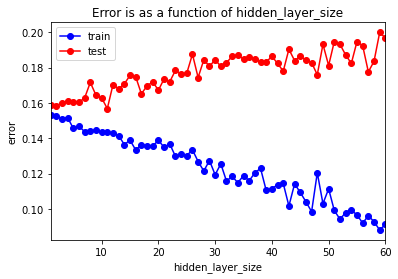

In [19]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error is as a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

print(f"Train: минимальное значение ошибки = {np.min(train_err)}, число нейронов = {hidden_layer_size[np.argmin(train_err)]}")
print(f"Test: минимальное значение ошибки = {np.min(test_err)}, число нейронов = {hidden_layer_size[np.argmin(test_err)]}")

Train: максимальное значение accuracy = 0.912, число нейронов = 59
Test: максимальное значение accuracy = 0.8432, число нейронов = 11


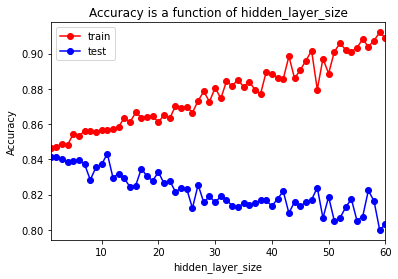

In [20]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy is a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()

print(f"Train: максимальное значение accuracy = {np.max(train_acc)}, число нейронов = {hidden_layer_size[np.argmax(train_acc)]}")
print(f"Test: максимальное значение accuracy = {np.max(test_acc)}, число нейронов = {hidden_layer_size[np.argmax(test_acc)]}")

## Подбор числа нейронов в двухслойном классификаторе

In [21]:
n = 10
sizes = np.linspace(1, 60, n).astype(int)
test_err = np.zeros((n, n))
train_err = np.zeros((n, n))
train_acc = np.zeros((n, n))
test_acc = np.zeros((n, n))

for i, size_1 in tqdm(enumerate(sizes)):
    for j, size_2 in enumerate(sizes):
        model = MLPClassifier(hidden_layer_sizes=(size_1, size_2, ), 
                              solver='adam', activation='relu', max_iter=3000, random_state=13)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_err[i][j] = np.mean(y_train != y_train_pred)
        test_err[i][j] = np.mean(y_test != y_test_pred)

        train_acc[i][j] = accuracy_score(y_train, y_train_pred)
        test_acc[i][j] = accuracy_score(y_test, y_test_pred)

10it [21:11, 127.19s/it]


Train: минимальное значение ошибки = 0.012533333333333334, число нейронов = (8, 8)
Test: минимальное значение ошибки = 0.154, число нейронов = (0, 6)


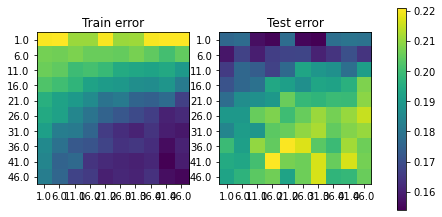

In [22]:
plt.subplot(121)
plt.title("Train error")
plt.imshow(train_err)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

plt.subplot(122)
plt.title("Test error")
plt.imshow(test_err)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

cax = plt.axes([0.96, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

train_min_loss = np.where(train_err == np.min(train_err))
test_min_loss = np.where(test_err == np.min(test_err))

train_min_loss_sizes = np.where(train_err == np.min(train_err))
print(f"Train: минимальное значение ошибки = {np.min(train_err)}, число нейронов = (" \
      f"{train_min_loss_sizes[0][0]}, {train_min_loss_sizes[1][0]})")

test_min_loss_sizes = np.where(test_err == np.min(test_err))
print(f"Test: минимальное значение ошибки = {np.min(test_err)}, число нейронов = (" \
      f"{test_min_loss_sizes[0][0]}, {test_min_loss_sizes[1][0]})")

Train: максимальное значение accuracy = 0.9874666666666667, число нейронов = (8, 8)
Test: максимальное значение accuracy = 0.846, число нейронов = (0, 6)


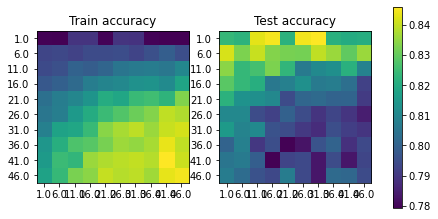

In [23]:
plt.subplot(121)
plt.title("Train accuracy")
plt.imshow(train_acc)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

plt.subplot(122)
plt.title("Test accuracy")
plt.imshow(test_acc)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

train_max_acc = np.where(train_acc == np.max(train_acc))
test_max_acc = np.where(test_acc == np.max(test_acc))


train_max_acc_sizes = np.where(train_acc == np.max(train_acc))
print(f"Train: максимальное значение accuracy = {np.max(train_acc)}, число нейронов = (" \
      f"{train_max_acc_sizes[0][0]}, {train_max_acc_sizes[1][0]})")

test_max_acc_sizes = np.where(test_acc == np.max(test_acc))
print(f"Test: максимальное значение accuracy = {np.max(test_acc)}, число нейронов = (" \
      f"{test_max_acc_sizes[0][0]}, {test_max_acc_sizes[1][0]})")

## Подбор параметра регуляризации

In [25]:
alpha_arr = np.logspace(-5, 5, 50)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in tqdm(alpha_arr):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (22,), 
                              solver='adam', activation='relu', max_iter=1000, random_state=13)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:46<00:00,  3.33s/it]


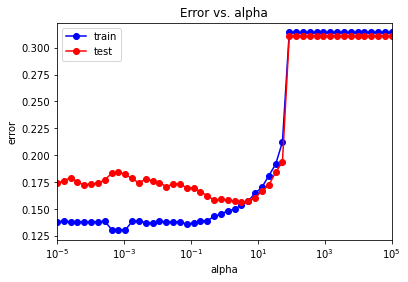

In [26]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

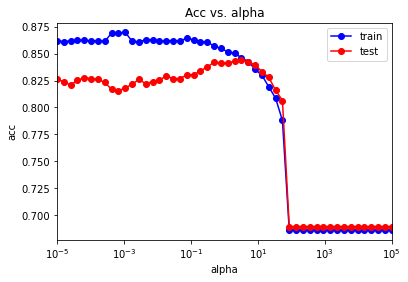

In [27]:
plt.semilogx(alpha_arr, train_acc, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Acc vs. alpha')
plt.xlabel('alpha')
plt.ylabel('acc')
plt.legend()

# Выводы
### Подбор числа нейронов в однослойном классификаторе
1. Переобучения нет, следовательно в моделе нет высоких весовых значений.
2. Недообучения так же нет, то есть модель достаточно сложная, чтобы решить поставленную задачу.
3. Максимальное значение accuracy = 84%

### Подбор числа нейронов в двухслойном классификаторе
1. Переобучения и недобучения нет.
2. Максимальное значение accuracy = 85%

### Подбор параметра регуляризации
C ростом коэффициента регуляризации растет ошибка и падает accuracy, что говорит о том, что после обучения у модели не возникает больших значения весовых коэффициентов, а значит нет переобучения у модели.